# Analyzing Data Using FHIR Bulk Data Access (Flat FHIR)
https://hl7.org/fhir/uv/bulkdata/

In this notebook, we'll implement a very simple client that can access and download clinical data in the FHIR format using the [bulk data export request](https://hl7.org/fhir/uv/bulkdata/export/index.html#bulk-data-kick-off-request) from the [Demo SMART Bulk Data Server](https://bulk-data.smarthealthit.org). This notebook is originally based on a [FHIR Connectathon Project](https://github.com/plangthorne/python-fhir/blob/master/demo/BulkDataDemo.ipynb), but we're ignoring the authorization aspects of the communication flow for simplicity's sake. If you'd like to read more about the authentication flow, see the [Smart Backend Services: Authorization Guide](https://hl7.org/fhir/uv/bulkdata/authorization/index.html).

To start off our tutorial, let's quickly breeze through some slides provided in the [Resources](https://hl7.org/fhir/uv/bulkdata/#resources) section of the documentation. [Click here](https://docs.google.com/presentation/d/14ZHmam9hwz6-SsCG1YqUIQnJ56bvSqEatebltgEVR6c/edit#slide=id.g8c17644f87_23_919) to follow along!

## Motivation: Generate a Data Analysis Pipeline

Creating maintainable and comprehensive pipelines for data analysis - where the process is as automated and parameterized as possible - is incredibly useful in research, with benefits including:

- rapid iteration
- reprucibility
- collaboration
- easier updates
- clarity
- debugging
- documentation
 
Also, pipelines can be used as great starting points for building more generalizable automated tools. 

To make such a pipeline for analyzing EHR data, we want to to able to write code to: 
1. Query the data source for the desired data
2. Transform this data into a format suitable for analysis
3. Analyze it with the desired data analysis software


In this tutorial, we'll demonstrate this approach using FHIR Bulk Data Access to grab the required data and Python to run a simple analysis. 
1. Request the data we want to analyze from the FHIR server
2. Access and transform the data for analysis using [pandas](https://pandas.pydata.org/)

## Scenario: Patient Vaccination Analysis

Since we're currently limited to a synthetic dataset and a nascent API that's at the early stages of development, the scenario we will use is - by necessity - a bit contrived.  

We're going to focus on two specific resources - [Patients](https://www.hl7.org/fhir/patient.html) and [Immunizations](https://www.hl7.org/fhir/immunization.html) to investigate vaccination rates in our Patient pool. 

Feel free to adapt this example to your own scenario with a focus on other resources. 



## Initial Setup
1. Download and install Anaconda: https://www.anaconda.com/distribution/

2. Install the [requests](http://docs.python-requests.org/en/master/), [numpy](https://pypi.org/project/numpy/), [pandas](https://pandas.pydata.org/), and [matplotlib](https://matplotlib.org/) packages: `conda install requests pandas numpy matplotlib`.

3. Clone project from github: `git clone https://github.com/uw-fhir/bulk-fhir-tutorial.git`

4. Open `bulk-fhir-tutorial.ipynb` in JupyterLab or Jupyter Notebook

## Server Configuration

We'll start by reading required config parameters, which define the FHIR server and other options. We'll be testing against the [demo SMART Bulk Data Server](https://bulk-data.smarthealthit.org). 

In [8]:
import yaml
    
with open('config.yaml') as f:
    config = yaml.safe_load(f)

## 1. Explore the Dataset

First, we're going to use the [SMART Patient Browser](https://patient-browser.smarthealthit.org/index.html?config=r3#/) tool to explore the patients and associated data. 

Click on the tool and play around with it a bit, clicking on the different listed [Patients](https://www.hl7.org/fhir/patient.html) and then exploring their associated FHIR Resources like [Immunizations](https://www.hl7.org/fhir/immunization.html) or [Encounters](https://www.hl7.org/fhir/encounter.html). 

## 2. Generate the Query using the Bulk Data Export Request Flow

Now that we have a feel for the data, we need to decide what specific resources we're interested in and generate a query by using the proper [FHIR Bulk Data query parameters](https://github.com/HL7/bulk-data/blob/master/spec/export/index.md#query-parameters). 

We can first try out our downloads by using a very simple tool made by the SMART folks - [The FHIR Bulk Downloader](https://bulk-data.smarthealthit.org/sample-app/index.html?server=https%3A%2F%2Fbulk-data.smarthealthit.org%2FeyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0%2Ffhir)

We'll focus on the Patient-level export since we're only interested in data that is in some way associated with a Patient (see https://github.com/smart-on-fhir/fhir-bulk-data-docs/blob/master/export.md#query-parameters for more information), and want to download resources that will be useful for analysis. 

In this example, we'll be looking at [Immunizations](https://www.hl7.org/fhir/immunization.html). 

1. Go to [The FHIR Bulk Downloader](https://bulk-data.smarthealthit.org/sample-app/index.html?server=https%3A%2F%2Fbulk-data.smarthealthit.org%2FeyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0%2Ffhir)

2. Select the desired resources, patient groups, and time frame. 

3. Notice how each selection modifies the download link url.

4. Try modifying the url yourself using the available query parameters, and see what happens after pressing `Download`. 
   
   For example, type this in: `https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0/fhir/Patient/$export?_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female`
   
5. Note this generated url string for use later in the tutorial to get the desired dataset. I will be using the query above. 

## 3. Send Bulk Data Request

Now that we know what query string we'll use to access our desired dataset, we can send a request to the FHIR endpoint which will tell the endpoint to start compiling the data we require. 

This manual bit of work slightly intimidating, and you can leverage the fhir bulk data clients that already exist: https://github.com/smart-on-fhir/fhir-bulk-data-docs/blob/master/implementations.md#client. [This notebook](https://github.com/plangthorne/python-fhir/blob/master/demo/BulkDataDemo.ipynb) demos the use of one such client. 

See https://pasteapp.com/p/Ggufyqh11of/s/haevhk9l for an overview of the flow being executed here. 

In [9]:
import requests
import urllib

fhir_endpoint = config["server"]
export_level = '/Patient/$export'
types = ["Patient", "Immunization"]
typeFilters = ["Patient?gender=female", "Immunization?vaccine-code=140"]

headers = {'Accept': 'application/fhir+json', "Prefer": 'respond-async'}

payload = {'_type': ",".join(types), '_typeFilter': ",".join(typeFilters)}
payload_str = "&".join("%s=%s" % (k,v) for k,v in payload.items())
# temp
payload_str = "_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female"

request_url = fhir_endpoint + export_level

r = requests.get(request_url, headers=headers, params=payload_str)

display(payload_str)
display(r)
display(r.url)
display(r.json())

'_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female'

<Response [202]>

'https://bulk-data.smarthealthit.org/eyJlcnIiOiIiLCJwYWdlIjoxMDAwMCwiZHVyIjoxMCwidGx0IjoxNSwibSI6MX0/fhir/Patient/$export?_type=Patient,Immunization&_typeFilter=Immunization%3Fvaccine-code%3D140,Patient%3Fgender=female'

{'resourceType': 'OperationOutcome',
 'text': {'status': 'generated',
  'div': '<div xmlns="http://www.w3.org/1999/xhtml"><h1>Operation Outcome</h1><table border="0"><tr><td style="font-weight:bold;">information</td><td>[]</td><td><pre>Your request has been accepted. You can check it\'s status at &quot;https://bulk-data.smarthealthit.org/fhir/bulkstatus/4c6259b9b327c03fb49d961cdad5aef1&quot;</pre></td></tr></table></div>'},
 'issue': [{'severity': 'information',
   'code': 'processing',
   'diagnostics': 'Your request has been accepted. You can check it\'s status at "https://bulk-data.smarthealthit.org/fhir/bulkstatus/4c6259b9b327c03fb49d961cdad5aef1"'}]}

## 4. Wait for Data

Now that the server is compiling the datasets, we need to wait until the endpoint is ready to send the data. We continuously query the provided location until the server is done.

In [10]:
from time import sleep

def parse_manifest(response):
    return [_.get('url') for _ in response.json()['output']]

location = r.headers['Content-Location']

while True:
    sleep(0.5)
    response = requests.get(location)
    display(response.status_code)
    if response.status_code == 200:
        manifest = parse_manifest(response)
        break
    
display(manifest)

202

202

202

202

202

202

202

202

200

['https://bulk-data.smarthealthit.org/eyJpZCI6IjRjNjI1OWI5YjMyN2MwM2ZiNDlkOTYxY2RhZDVhZWYxIiwib2Zmc2V0IjowLCJsaW1pdCI6MTAwMDB9/fhir/bulkfiles/1.Immunization.ndjson',
 'https://bulk-data.smarthealthit.org/eyJpZCI6IjRjNjI1OWI5YjMyN2MwM2ZiNDlkOTYxY2RhZDVhZWYxIiwib2Zmc2V0IjowLCJsaW1pdCI6MTAwMDB9/fhir/bulkfiles/1.Patient.ndjson']

## Load and Transform the Data

Now that we have access to both the patient and immunization data, we should load the data, link patients and vaccinations together, and transform it into a form suitable for analysis. 


In [11]:
import json

def iterate_over_json(url):
    data = requests.get(url)
    for item in data.iter_lines():
        yield json.loads(item)    

json_data = list(map(iterate_over_json, manifest))

json_data


[<generator object iterate_over_json at 0x000002154E6AF9E0>,
 <generator object iterate_over_json at 0x000002154E6AFC80>]

In [12]:
import itertools as it
import numpy as np
import pandas as pd

vaccinations = pd.DataFrame(list(json_data[0]))
patients = pd.DataFrame(list(json_data[1]))

In [13]:
patients.head()

,resourceType,id,text,extension,identifier,name,telecom,gender,birthDate,address,maritalStatus,multipleBirthBoolean,communication,multipleBirthInteger
0,Patient,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Lemke', 'given...","[{'system': 'phone', 'value': '555-532-1156', ...",male,1965-01-13,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
1,Patient,58c297c4-d684-4677-8024-01131d93835e,"{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Wintheiser', '...","[{'system': 'phone', 'value': '555-712-4709', ...",female,1971-04-05,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
2,Patient,538a9a4e-8437-47d3-8c01-1a17dca8f0be,"{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Alaniz', 'give...","[{'system': 'phone', 'value': '555-446-6900', ...",male,1923-03-24,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
3,Patient,c6c60742-8694-46e4-bb42-b00bf6d8b536,"{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Walsh', 'given...","[{'system': 'phone', 'value': '555-436-4287', ...",female,1965-10-27,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN
4,Patient,fbfec681-d357-4b28-b1d2-5db6434c7846,"{'status': 'generated', 'div': '<div xmlns=""ht...",[{'url': 'http://hl7.org/fhir/StructureDefinit...,[{'system': 'https://github.com/synthetichealt...,"[{'use': 'official', 'family': 'Bednar', 'give...","[{'system': 'phone', 'value': '555-405-4909', ...",female,1942-07-04,[{'extension': [{'url': 'http://hl7.org/fhir/S...,{'coding': [{'system': 'http://terminology.hl7...,False,[{'language': {'coding': [{'system': 'urn:ietf...,NaN


In [14]:
vaccinations.head()

,resourceType,id,status,vaccineCode,patient,encounter,occurrenceDateTime,primarySource
0,Immunization,c3f2624a-413e-4707-b58f-7946fe396bdf,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...,{'reference': 'Patient/6c5d9ca9-54d7-42f5-bfae...,{'reference': 'Encounter/7518242e-0b07-41d2-8c...,2011-02-02T16:30:49-05:00,True
1,Immunization,00eb0348-af11-4809-a711-6f3db39fdc1a,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...,{'reference': 'Patient/6c5d9ca9-54d7-42f5-bfae...,{'reference': 'Encounter/d4e1370a-a679-4570-a3...,2013-02-06T16:30:49-05:00,True
2,Immunization,118d01eb-6fef-49a6-b5f2-60537dbc3419,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...,{'reference': 'Patient/6c5d9ca9-54d7-42f5-bfae...,{'reference': 'Encounter/f85c9571-e416-41e5-af...,2015-01-14T16:30:49-05:00,True
3,Immunization,65c980d4-0f72-4293-afe6-51d940930aaf,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...,{'reference': 'Patient/6c5d9ca9-54d7-42f5-bfae...,{'reference': 'Encounter/f85c9571-e416-41e5-af...,2015-01-14T16:30:49-05:00,True
4,Immunization,d63bbe3f-1701-4f77-ad43-2ed85aaa838d,completed,{'coding': [{'system': 'http://hl7.org/fhir/si...,{'reference': 'Patient/6c5d9ca9-54d7-42f5-bfae...,{'reference': 'Encounter/cef72deb-ac37-4b71-ba...,2016-01-20T16:30:49-05:00,True


These look very much like the objects we explored in the [Patient](https://patient-browser.smarthealthit.org/index.html?config=r3#/patient/6) and [Object Viewers](http://docs.smarthealthit.org/fhir-viewer/index.html?url=https%3A%2F%2Fr3.smarthealthit.org%2FImmunization%2FRES177065).

Now, we need to transform the data a bit to get at the bits we want to use in analysis:

In [16]:
def clean_vaccination(row):
    # Re-order Rows
    outrow = row.reindex(['id', 'date', 'patient', 'status', 'vaccineCode'])
    # Extract nested patient id
    outrow['patient'] = outrow['patient']['reference'].split('/')[1]
    #print(row['patient'])
    # Extract nested code value
    outrow['vaccineCode'] = int(outrow['vaccineCode']['coding'][0]['code'])
    return(outrow)

def clean_patient(row):
    # Select only a couple columns for simplicity and reorder them
    outrow = row[['id', 'name', 'birthDate', 'gender', 'maritalStatus']]
    address = row['address'][0]
    name = row['name'][0]
    
    outrow['name'] = f"{name['family']}, {name['given'][0]}"
    
    outrow['address'] = f"{address['city']}, {address['state']} {address['postalCode'] if ('postalCode' in address) else '' }"
    outrow['maritalStatus'] = outrow['maritalStatus']['text'] if not pd.isna(outrow['maritalStatus']) else ""
    return(outrow)


clean_vaccinations = vaccinations.apply(clean_vaccination, result_type='expand', axis=1)
clean_patients = patients.apply(clean_patient, result_type='expand', axis = 1)

clean_patients.head()

,id,name,birthDate,gender,maritalStatus,address
0,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"Lemke, Abram",1965-01-13,male,M,"Easthampton, Massachusetts 01027"
1,58c297c4-d684-4677-8024-01131d93835e,"Wintheiser, Aleta",1971-04-05,female,M,"Everett, Massachusetts 02149"
2,538a9a4e-8437-47d3-8c01-1a17dca8f0be,"Alaniz, Alfredo",1923-03-24,male,M,"Brockton, Massachusetts 02351"
3,c6c60742-8694-46e4-bb42-b00bf6d8b536,"Walsh, Alyce",1965-10-27,female,M,"New Bedford, Massachusetts 02748"
4,fbfec681-d357-4b28-b1d2-5db6434c7846,"Bednar, Arnette",1942-07-04,female,M,"Randolph, Massachusetts 02368"


In [17]:
clean_vaccinations.head()

,id,date,patient,status,vaccineCode
0,c3f2624a-413e-4707-b58f-7946fe396bdf,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,140
1,00eb0348-af11-4809-a711-6f3db39fdc1a,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,140
2,118d01eb-6fef-49a6-b5f2-60537dbc3419,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,121
3,65c980d4-0f72-4293-afe6-51d940930aaf,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,140
4,d63bbe3f-1701-4f77-ad43-2ed85aaa838d,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,121


Finally, we will join these two data frames by the patient id to prepare the data for analysis. 

In [18]:
# Merge
merged = pd.merge(clean_patients, clean_vaccinations, left_on='id', right_on='patient')
merged.head()

,id_x,name,birthDate,gender,maritalStatus,address,id_y,date,patient,status,vaccineCode
0,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"Lemke, Abram",1965-01-13,male,M,"Easthampton, Massachusetts 01027",c3f2624a-413e-4707-b58f-7946fe396bdf,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,140
1,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"Lemke, Abram",1965-01-13,male,M,"Easthampton, Massachusetts 01027",00eb0348-af11-4809-a711-6f3db39fdc1a,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,140
2,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"Lemke, Abram",1965-01-13,male,M,"Easthampton, Massachusetts 01027",118d01eb-6fef-49a6-b5f2-60537dbc3419,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,121
3,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"Lemke, Abram",1965-01-13,male,M,"Easthampton, Massachusetts 01027",65c980d4-0f72-4293-afe6-51d940930aaf,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,140
4,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,"Lemke, Abram",1965-01-13,male,M,"Easthampton, Massachusetts 01027",d63bbe3f-1701-4f77-ad43-2ed85aaa838d,NaN,6c5d9ca9-54d7-42f5-bfae-a7c19cd217f2,completed,121


Since we want to use age in the analysis but are given birth date, we need to calculate this value.

In [19]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

merged['age'] = merged['birthDate'].apply(lambda birthDate: relativedelta(datetime.today(), datetime.strptime(birthDate, '%Y-%m-%d')).years) 

merged.tail()

,id_x,name,birthDate,gender,maritalStatus,address,id_y,date,patient,status,vaccineCode,age
1282,a845ead4-d9de-42eb-b4b5-eb21a8963578,"Pagac, Yi",1968-04-20,female,S,"Monson, Massachusetts",8da42317-d17a-4a0a-8537-ac445088e135,NaN,a845ead4-d9de-42eb-b4b5-eb21a8963578,completed,121,52
1283,a845ead4-d9de-42eb-b4b5-eb21a8963578,"Pagac, Yi",1968-04-20,female,S,"Monson, Massachusetts",75727fe9-ac78-4da4-93a2-43119dc6176a,NaN,a845ead4-d9de-42eb-b4b5-eb21a8963578,completed,140,52
1284,a845ead4-d9de-42eb-b4b5-eb21a8963578,"Pagac, Yi",1968-04-20,female,S,"Monson, Massachusetts",09f4e407-f5ae-4b6d-bdb7-3a6f8ca82fbe,NaN,a845ead4-d9de-42eb-b4b5-eb21a8963578,completed,121,52
1285,a845ead4-d9de-42eb-b4b5-eb21a8963578,"Pagac, Yi",1968-04-20,female,S,"Monson, Massachusetts",6f312204-50e8-4b47-b8ea-b7135d1e9646,NaN,a845ead4-d9de-42eb-b4b5-eb21a8963578,completed,140,52
1286,a845ead4-d9de-42eb-b4b5-eb21a8963578,"Pagac, Yi",1968-04-20,female,S,"Monson, Massachusetts",9748b383-8394-4fbc-a2bf-b966306d9fe0,NaN,a845ead4-d9de-42eb-b4b5-eb21a8963578,completed,113,52


And now, we can do our analysis!

We're going to just plot a simple relationship between the number of vaccinations and age. 

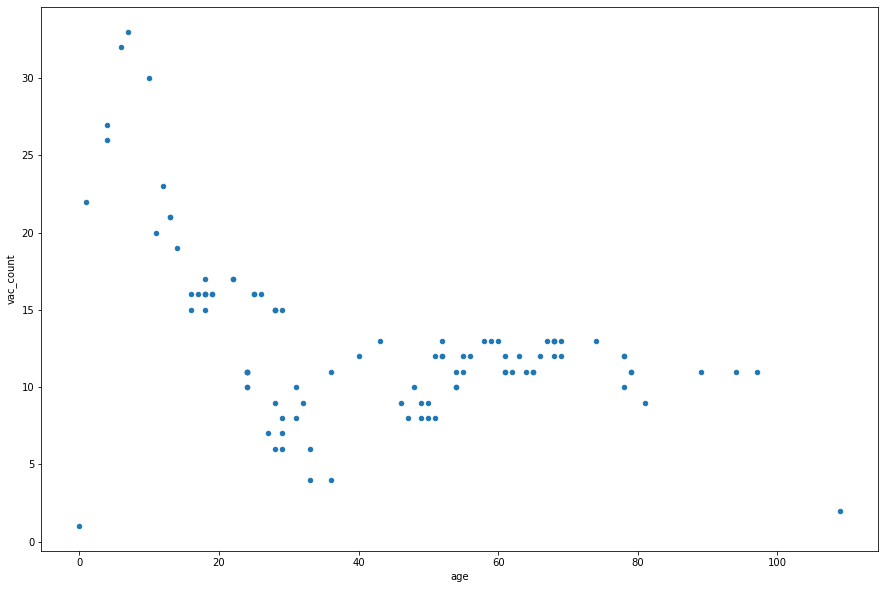

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]


agg = merged.groupby(['patient', 'age']).count()['vaccineCode']

plot_df = pd.DataFrame({'age': list(agg.index.get_level_values(1)), 'vac_count': agg}) 

plot_df.head()

plot_df.plot.scatter(x='age', y='vac_count')


Now, let's focus our analysis on only those vaccinations that have code 140 - flu shots. 

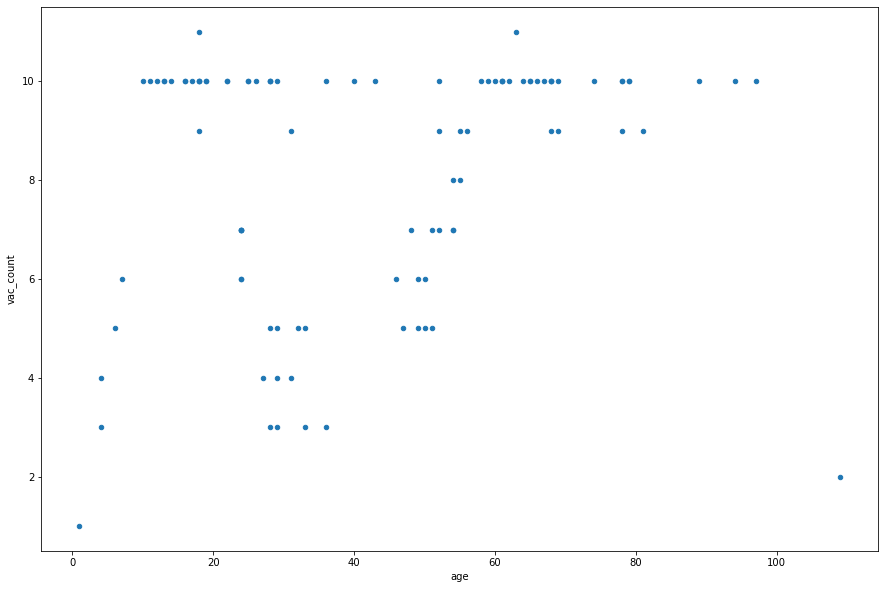

In [21]:
agg = merged[merged.vaccineCode == 140].groupby(['patient', 'age']).count()['vaccineCode']

plt.rcParams['figure.figsize'] = [15, 10]

plot_df = pd.DataFrame({'age': list(agg.index.get_level_values(1)), 'vac_count': agg}) 

plot_df.head()

plot_df.plot.scatter(x='age', y='vac_count')

## Role in a Learning Health System

Although this is a contrived example and very simple analysis, this type of figure might be useful in many different contexts - and could be fed back upstream to support decision makers at the public, population, practice, or patient level. 